In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import BoxStyle
from matplotlib.path import Path
from matplotlib import rcParams
rcParams['mathtext.default'] = 'regular'

%matplotlib inline

In [24]:
lr_df = pd.read_csv('../data/lightResponseData.csv')

# note, during the curve of line 1.10.19 the licor had a problem half way through and the leaf was in darkness for 5-10 mins
lr_df = lr_df[~lr_df['plant'].isin(['1.10.19_5'])]

# Use the first measurment at the highest light level
lr_df = lr_df[~lr_df['which_1500'].isin(['second'])]

grouped_df = lr_df.groupby(['Q_rounded', 'plot', 'type']).agg({'A': ['mean', 'std'], 'PhiPS2': ['mean', 'std']})
grouped_df.columns = ['A_mean', 'A_std', 'PhiPS2_mean', 'PhiPS2_std']
grouped_df = grouped_df.reset_index()

In [25]:
class ExtendedTextBox(BoxStyle._Base):
    """
    An Extended Text Box that expands to the axes limits 
                        if set in the middle of the axes
    """

    def __init__(self, pad=0.3, width=500.):
        """
        width: 
            width of the textbox. 
            Use `ax.get_window_extent().width` 
                   to get the width of the axes.
        pad: 
            amount of padding (in vertical direction only)
        """
        self.width=(width*0.9)
        self.pad = pad
        super(ExtendedTextBox, self).__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        x0 and y0 are the lower left corner of original text box
        They are set automatically by matplotlib
        """
        # padding
        pad = mutation_size * self.pad

        # we add the padding only to the box height
        height = height + 2.*pad
        # boundary of the padded box
        y0 = y0 - pad
        y1 = y0 + height
        _x0 = x0
        x0 = _x0 +width /2. - self.width/2.
        x1 = _x0 +width /2. + self.width/2.

        cp = [(x0, y0),
              (x1, y0), (x1, y1), (x0, y1),
              (x0, y0)]

        com = [Path.MOVETO,
               Path.LINETO, Path.LINETO, Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path
    

# register the custom style
BoxStyle._style_list["ext"] = ExtendedTextBox

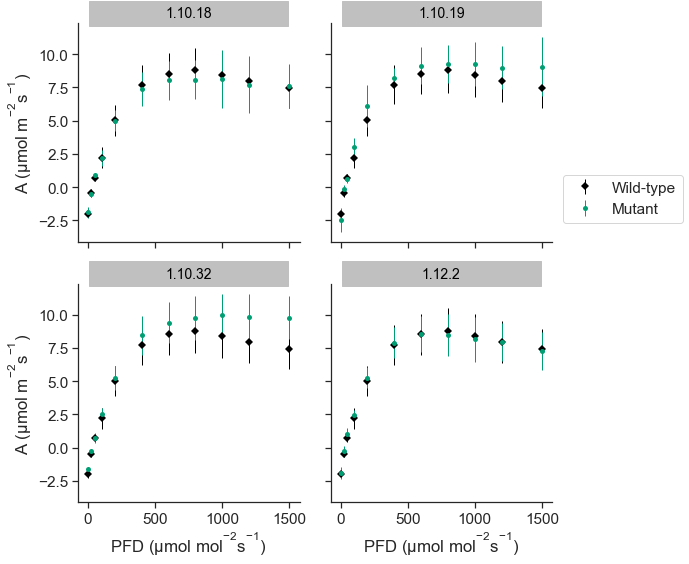

In [27]:
# sns.plotting_context()
sns.set(font_scale = 1.4, font="Arial")
sns.set_style(style='ticks')

# Choose hue colour palette
colours = ['#000000', '#009E73']

grid = sns.FacetGrid(grouped_df, col="plot", col_order=['1.10.18', '1.10.19', '1.10.32', '1.12.2'], hue="type", hue_order=['wt', 'mutant'],
                     palette=colours, col_wrap=2, size=4, aspect=1, hue_kws=dict(marker=["D", "o"]))

grid.map(plt.errorbar, "Q_rounded", "A_mean", "A_std", markersize=5, linewidth=1.2, linestyle='', elinewidth=1, capsize=1, 
        markeredgecolor='black', markeredgewidth=0)


# Adjust position abd labels of legend
legend_ax = grid.axes.flat[3]
handles, labels = legend_ax.get_legend_handles_labels()
leg = plt.legend(handles[0:2],['Wild-type', 'Mutant'], bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)


# Set axis labels
grid.set_axis_labels(x_var="PFD ($\mu$mol mol$^{-2}$s$^{-1}$)", y_var="A ($\mu$mol m$^{-2}$s$^{-1}$)")


# Set titles 
grid.set_titles("{col_name}")
for ax in grid.axes:
    # set the title position to the horizontal center (0.5) of the axes
    title = ax.set_title(ax.get_title(), position=(.5, 1.0), backgroundcolor="silver", color='black', 
                         size=14)
    # set the box style of the title text box to our custom box
    bb = title.get_bbox_patch()
    # use the axes' width as width of the text box
    bb.set_boxstyle("ext", pad=0.4, width=ax.get_window_extent().width )

plt.savefig("../figures/lrCurves.pdf", transparent=True, dpi=300, bbox_inches='tight')